In [1]:
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
#constants 
c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [3]:
#this file reads in the spectrum of the star, which is required to calculate ionization-recombination in the gas. We will use a solar spectrum for now

##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

#we keep the shape of the spectrum the same but change the magnitude. (I.e stronger light)

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

#normalize EUV flux hitting planet
norm_ss = normalize_spectrum(ss, 10**4)

#for those changing stellar spectrum, you want to change this number (10**4 above) and see how that affects results

In [8]:
myTorus = torus.Torus(species = {'h': 1, 'he' : 0.11}, stellar_spectrum = norm_ss, Ms = 1e33, Rs = 7e10, ap = 0.02*1.5e13, T = 10**4, D = 0.02*1.5e13, nH = 1e7)

#species - dictionary of included species 
#Ms - mass of star
#Rs - radius of star
#ap - orbital distance of planet
#T - temperature of gas
#D - size of disc
#nH - number density of hydrogen in torus

#I want you to change these parameters and see how the equivalent width varies 

myTorus.calculate_ion_abundances_all_species()
EW = myTorus.get_EW()

print(EW)

#what i want you to do is make a plot of how the equivalent width changes as a function of the parameter you are changing (maybe do 10 points).
#remember the equivalent width is the area inclosed by the curve of the spectrum (see below)
#for some parameters you will want to vary them logorithmically and some linearly - think why that is
#try and explain why the EW width is varying in this way physically 


0.000284741836367175
(312, 400)
282.6608391851212


Text(0, 0.5, 'normalized flux')

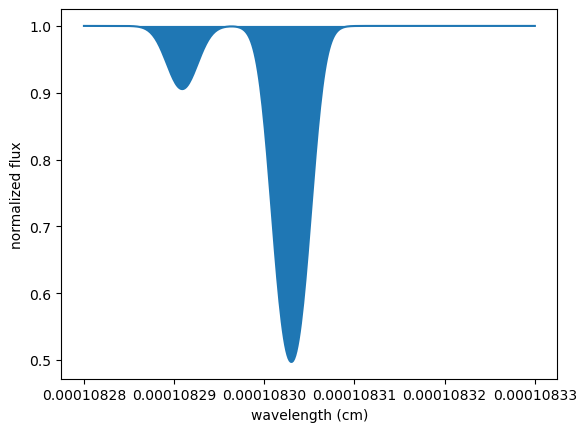

In [17]:
#this is an example absorption spectrum
#this is showing how much of the stellar light is absorbed at each wavelength. 1 means none of it is absorbed. 0 means all of it
#the equivalent width is the area of the above the curve bounded by the line y=1, i.e the shaded region

wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
#intensity = myTorus.do_transit_He()
constline = np.ones(len(wavgrid))

fig, ax = plt.subplots()
ax.plot(wavgrid, intensity)
ax.fill_between(wavgrid, intensity, 1)
ax.set_xlabel('wavelength (cm)')
ax.set_ylabel('normalized flux')